# Analysis of tweets on education in ChatGPT
## Bi-directional LSTM with RNN Architecture for 3 classes (5 iteration)
Neutral - 0
Positive - 1
Negative - 2


---


The data set : https://drive.google.com/file/d/1Lw3UNB5FCUQqm1Otk7EYBvpDyIHM7ALi/view?usp=drive_link

---


Orgin: https://www.kaggle.com/datasets/nutrientaxis/chatgpt-and-education-tweets-dataset?select=ChatGPT_Education_Tweets_Dataset.csv

In [ ]:
! pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 133.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 94.9 MB/s eta 0:00:00


In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2023-08-30 19:07:18--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-08-30 19:07:18--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-08-30 19:07:18--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertModel
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, TFBertModel
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
nltk.download("stopwords")
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

!ln -s /content/gdrive/My\ Drive/ /mydrive
!ls /mydrive

In [ ]:
%cd /mydrive/dataset/

/content/gdrive/My Drive/dataset


In [ ]:
df_data = pd.read_csv("ChatGPT_Education_Tweets_Dataset.csv")

In [ ]:
#labels to integers
df_data['sentiment'] = df_data['sentiment'].replace({'neutral': 0, 'positive': 1, 'negative': 2})

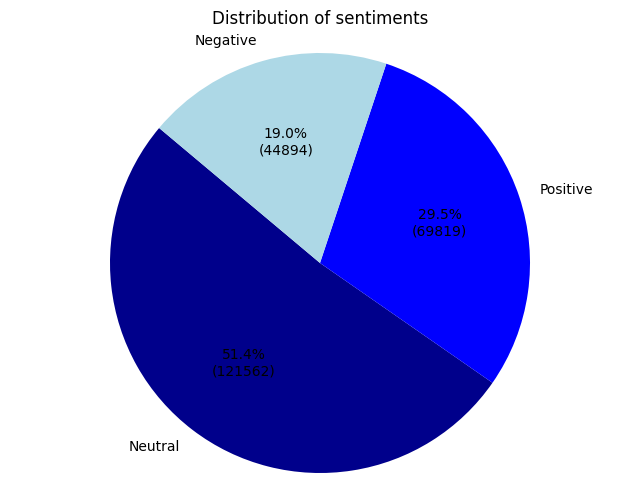

In [ ]:
label_counts = df_data['sentiment'].value_counts()

# Plot a pie chart
labels = ['Neutral', 'Positive', 'Negative']
sizes = label_counts.values
colors = ['darkblue', 'blue', 'lightblue']
explode = (0, 0, 0)  # explode 1st slice

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,autopct=lambda p: '{:.1f}%\n({:.0f})'.format(p, p/100 * sum(sizes)), startangle=140)
plt.axis('equal')
plt.title('Distribution of sentiments')
plt.show()


In [ ]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'one', 'two','more','chatgpt','chat','gpt','gpt4','username','chatbot','course','ai'])

In [ ]:
def preprocess(text):
    text = text.lower()
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in stop_words and word.lower() != 'more']
    return ' '.join(filtered_words)

In [ ]:
df_data['clean'] = df_data['text'].apply(preprocess)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_data['clean'])
sequences = tokenizer.texts_to_sequences(df_data['clean'])
maxlen = 40
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')



In [ ]:
embedding_dim = 100
glove_file_path = '/content/glove.6B.100d.txt'

# Load GloVe embeddings into a dictionary
embeddings_index = {}
with open(glove_file_path, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f'Loaded {len(embeddings_index)} word vectors.')

Loaded 400000 word vectors.


In [ ]:
word_embedding

array([-0.5985   , -0.46321  ,  0.13001  , -0.019576 ,  0.4603   ,
       -0.3018   ,  0.8977   , -0.65634  ,  0.66858  , -0.49164  ,
        0.037557 , -0.050889 ,  0.6451   , -0.53882  , -0.3765   ,
       -0.04312  ,  0.51384  ,  0.17783  ,  0.28596  ,  0.92063  ,
       -0.49349  , -0.48583  ,  0.61321  ,  0.78211  ,  0.19254  ,
        0.91228  , -0.055596 , -0.12512  , -0.65688  ,  0.068557 ,
        0.55629  ,  1.611    , -0.0073642, -0.48879  ,  0.45493  ,
        0.96105  , -0.063369 ,  0.17432  ,  0.9814   , -1.3125   ,
       -0.15801  , -0.54301  , -0.13888  , -0.26146  , -0.3691   ,
        0.26844  , -0.24375  , -0.19484  ,  0.62583  , -0.7377   ,
        0.38351  , -0.75004  , -0.39053  ,  0.091498 , -0.36591  ,
       -1.4715   , -0.45228  ,  0.2256   ,  1.1412   , -0.38526  ,
       -0.06716  ,  0.57288  , -0.39191  ,  0.31302  , -0.29235  ,
       -0.96157  ,  0.15154  , -0.21659  ,  0.25103  ,  0.096967 ,
        0.2843   ,  1.4296   , -0.50565  , -0.51374  , -0.4721

In [ ]:
word_index = tokenizer.word_index
num_words = min(len(word_index) + 1, len(embeddings_index))
embedding_matrix = np.zeros((num_words, embedding_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Split data into train and test sets 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df_data['sentiment'], test_size=0.2)


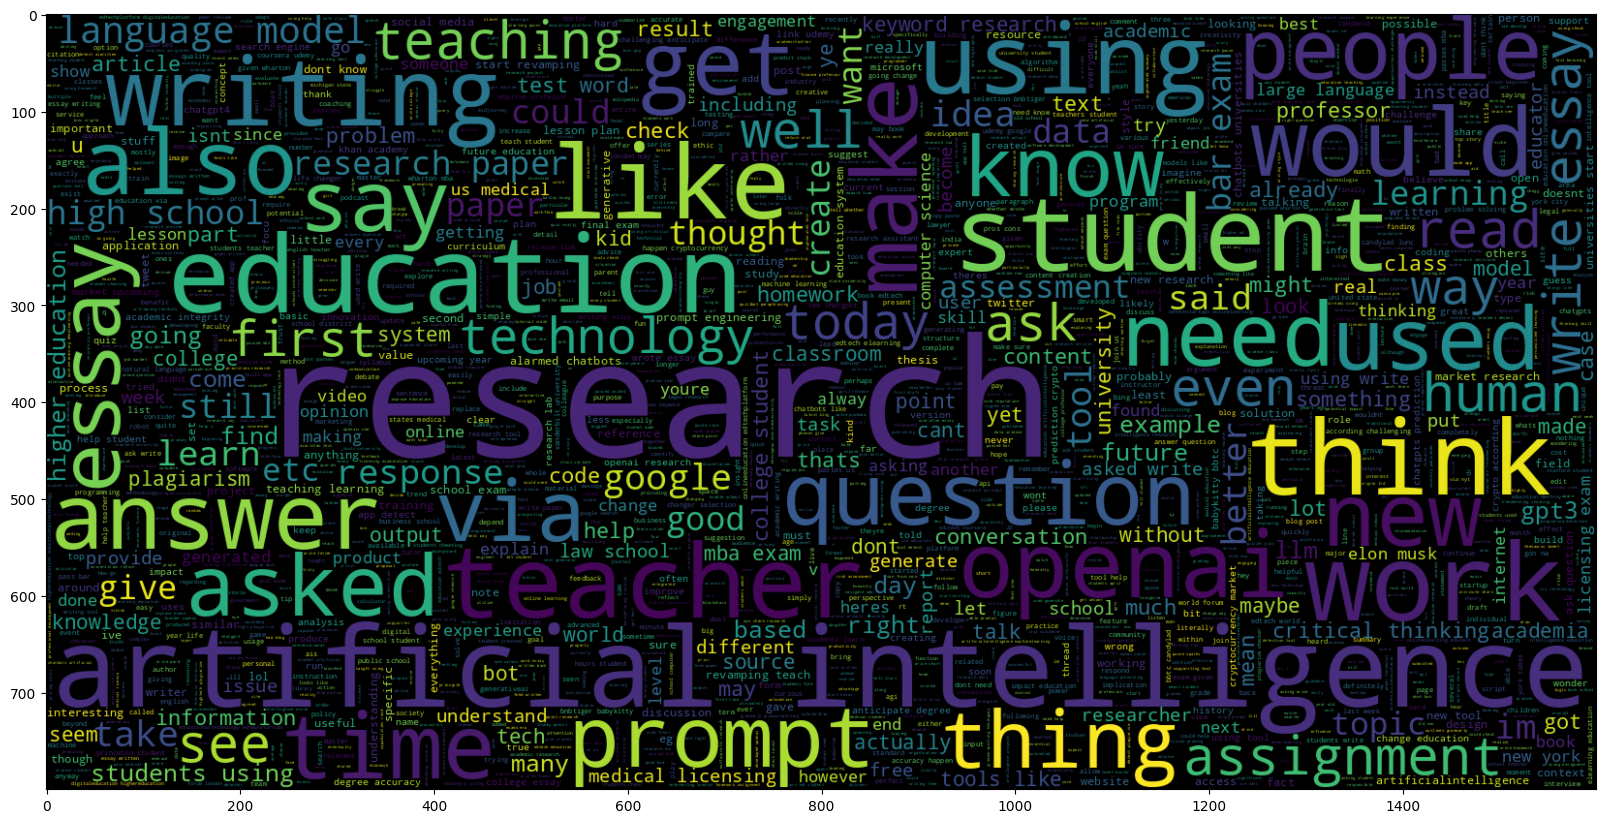

In [ ]:
#Neutral sentiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_data[df_data.sentiment==0].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_data[df_data.sentiment == 0].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_neutral = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_neutral))

research, artificial intelligence, work, education, student, think, teacher, like, using, writing


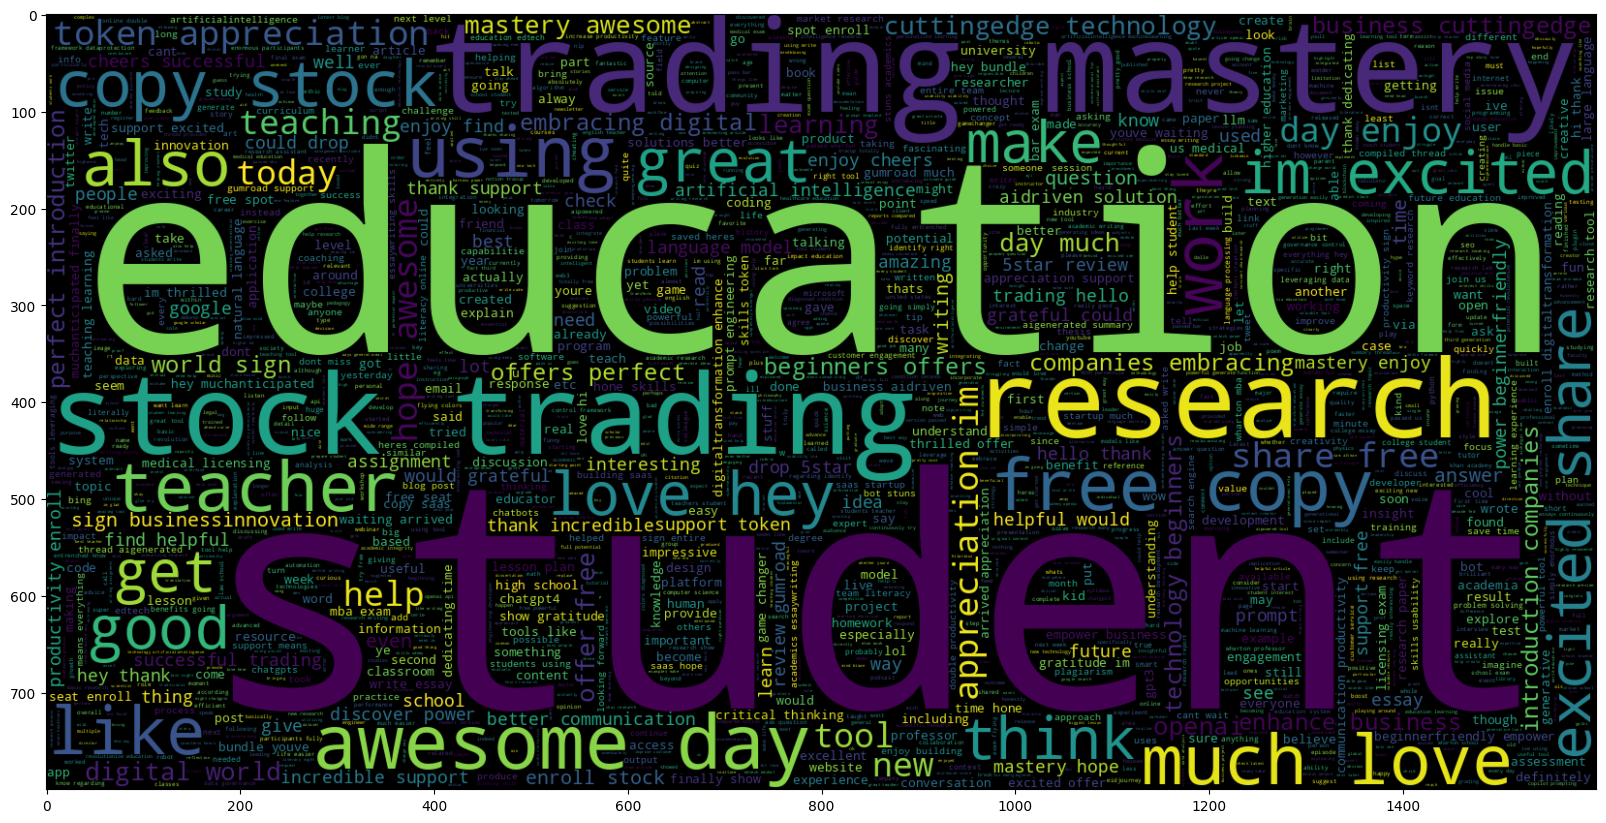

In [ ]:
#positive sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_data[df_data.sentiment==1].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_data[df_data.sentiment == 1].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_positive = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_positive))

student, education, trading mastery, stock trading, research, awesome day, free copy, using, much love, teacher


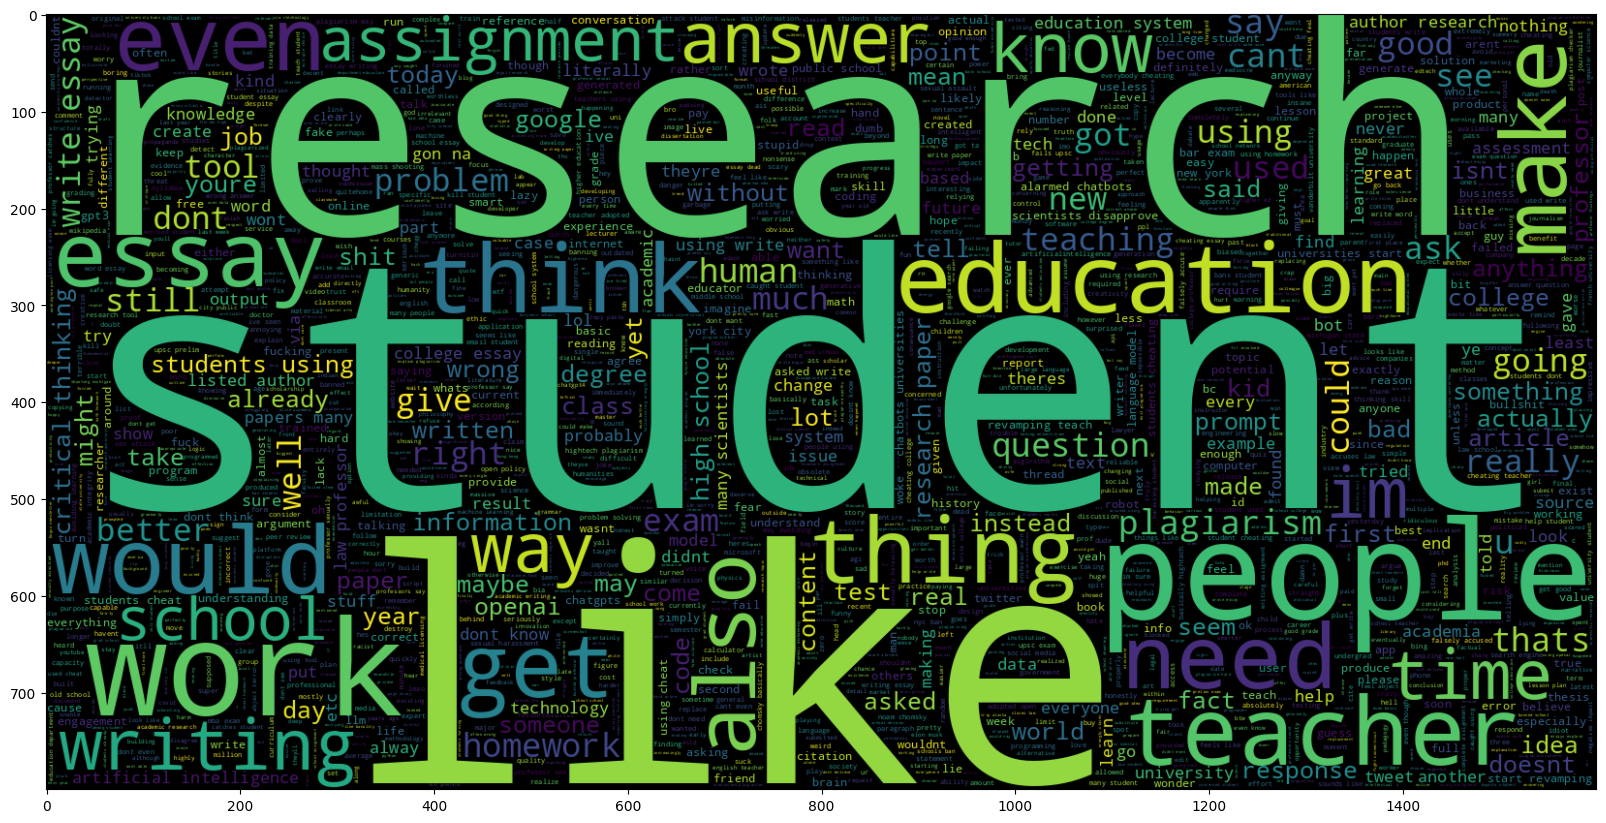

In [ ]:
#negative sntiment
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(df_data[df_data.sentiment==2].clean))
plt.imshow(wc, interpolation = 'bilinear')

In [ ]:
# Generate the WordCloud
wc = WordCloud(max_words=2000, width=1600, height=800, stopwords=stop_words).generate(" ".join(df_data[df_data.sentiment == 2].clean))

# Get the top 10 words and their frequencies
top_words = wc.words_
top_words_sorted = sorted(top_words.items(), key=lambda item: item[1], reverse=True)
top_10_words_negative = [word for word, freq in top_words_sorted[:10]]

print(", ".join(top_10_words_negative))

student, like, research, people, work, education, teacher, think, would, essay


In [ ]:
# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_data['clean'])
sequences = tokenizer.texts_to_sequences(df_data['clean'])
maxlen = 40

# Padding the sequences
padded_sequences = pad_sequences(sequences, maxlen=maxlen, padding='post', truncating='post')

embedding_dim = 100
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Split data into train and test sets 80:20
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, df_data['sentiment'], test_size=0.2)

In [ ]:
# Create a multi-class LSTM model
model = Sequential()
model.add(Embedding(len(tokenizer.word_index) + 1, embedding_dim, weights=[embedding_matrix], input_length=maxlen, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 100)           11615100  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              234496    
 l)                                                              
                                                                 
 dense (Dense)               (None, 3)                 771       
                                                                 
Total params: 11,850,367
Trainable params: 235,267
Non-trainable params: 11,615,100
_________________________________________________________________


In [ ]:
# Train the model
history = model.fit(x_train, y_train, batch_size=64, validation_split=0.1, epochs=5)


Epoch 1/5
2659/2659 [==============================] - 295s 110ms/step - loss: 0.6664 - acc: 0.7032 - val_loss: 0.6093 - val_acc: 0.7347
Epoch 2/5
2659/2659 [==============================] - 299s 113ms/step - loss: 0.5819 - acc: 0.7472 - val_loss: 0.5826 - val_acc: 0.7453
Epoch 3/5
2659/2659 [==============================] - 292s 110ms/step - loss: 0.5373 - acc: 0.7684 - val_loss: 0.5681 - val_acc: 0.7525
Epoch 4/5
2659/2659 [==============================] - 290s 109ms/step - loss: 0.5011 - acc: 0.7854 - val_loss: 0.5583 - val_acc: 0.7619
Epoch 5/5
2659/2659 [==============================] - 290s 109ms/step - loss: 0.4668 - acc: 0.8021 - val_loss: 0.5604 - val_acc: 0.7634


1477/1477 [==============================] - 41s 27ms/step
Model Accuracy: 0.761146968574754
Classification Report:
               precision    recall  f1-score   support

     neutral       0.77      0.82      0.79     24428
    positive       0.80      0.72      0.76     13738
    negative       0.68      0.68      0.68      9089

    accuracy                           0.76     47255
   macro avg       0.75      0.74      0.74     47255
weighted avg       0.76      0.76      0.76     47255



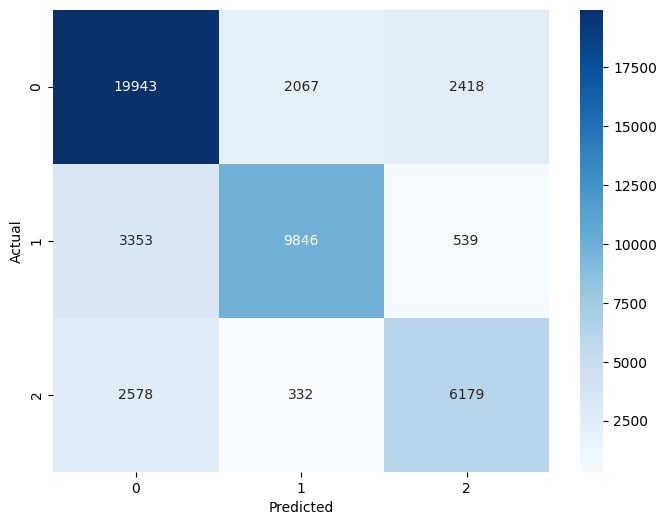

In [ ]:
# Classification and Evaluation
predictions = model.predict(x_test)
classification = np.argmax(predictions, axis=1)

accuracy = accuracy_score(y_test, classification)
print("Model Accuracy:", accuracy)

report = classification_report(y_test, classification, target_names=["neutral", "positive", "negative"])
print("Classification Report:\n", report)

cm = confusion_matrix(y_test, classification)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


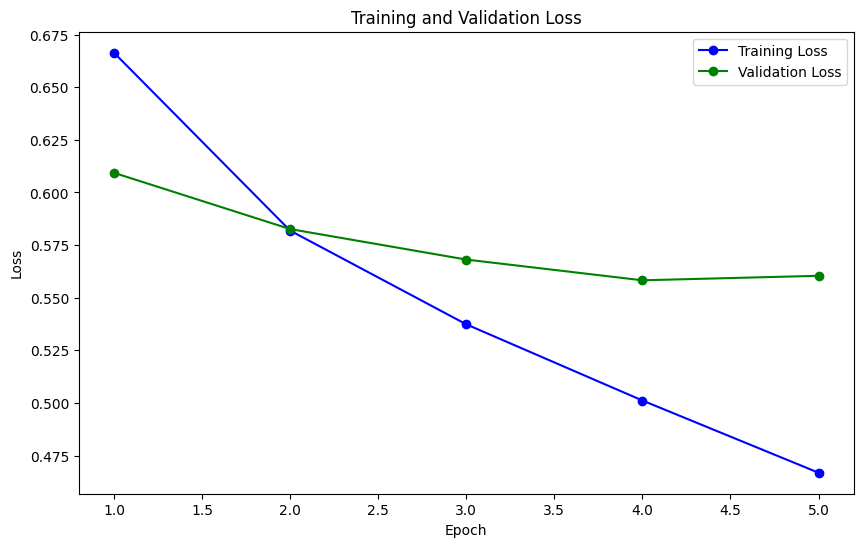

In [ ]:
# Get the training and validation loss from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(train_loss) + 1)

# Plot training loss and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'go-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
